In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
import yaml
import time
from copy import deepcopy
import pathlib
# from lmphoton.simulation import current_simulation as sim
import pandas as pd

import sys
sys.path.append("../")

# SPPD optical elements
from src.sppd_clm_optics import SPPDCLMOPTICS, SPPDCLMOPTICS_LAMBDA_AB

# PMIC drivers
from src.pikeriver_pmic import PMIC
from src.laser_control.pid import pid as PID
# Calibration and control
from src.sppd_clm import CONTROLLER

PATH = pathlib.Path("plot_style.mplstyle").parent.absolute()

plt.style.use("plot_style.mplstyle")
warnings.filterwarnings("ignore")

In [2]:
psi_matrix = pd.read_csv("../src/sppd_pic_psi_matrix.csv")
psi_array = psi_matrix.to_numpy()

In [3]:
psi_array

array([[21.51097509,  5.08407296,  3.52123696,  2.71050709,  2.13599349,
         1.67684629,  1.30600682,  1.00625296,  0.76493029,  0.57209962,
         0.41965429,  0.30086976,  0.21023242,  0.14325669,  0.09654442,
         0.06767482],
       [ 5.18068188, 20.76596028,  4.53258002,  3.07533522,  2.33794935,
         1.82871255,  1.42380508,  1.09865068,  0.83790855,  0.63014482,
         0.46624508,  0.33872242,  0.24148295,  0.16966508,  0.11957575,
         0.08861042],
       [ 3.59558395,  4.59869675, 20.32985915,  4.19111409,  2.79188315,
         2.09961249,  1.63381222,  1.26717409,  0.97536502,  0.74386875,
         0.56178075,  0.42041302,  0.31276742,  0.23330982,  0.17789009,
         0.14361862],
       [ 2.77738439,  3.13905852,  4.23861666, 20.04681586,  3.96447746,
         2.60394279,  1.94411186,  1.50989773,  1.17238359,  0.90665666,
         0.69851692,  0.53735346,  0.41484572,  0.32450359,  0.26151533,
         0.22257479],
       [ 2.20112626,  2.40354946,  2

In [4]:
with open("../src/sppd_data.yaml", "r", encoding="utf-8") as fh:
    sppd_data = yaml.load(fh, Loader=yaml.SafeLoader)
sppd_dfb_data = sppd_data['DFB']

In [5]:
sppd_dfb_data

{'IV': [3.339754422650176, 1.003425703613611],
 'LI': [0.3061936769909521, -0.0056601769911848775]}

In [6]:
current = 0.133

optical_power = sppd_dfb_data["LI"][0] * current + sppd_dfb_data["LI"][1]
electrical_power  = (sppd_dfb_data["IV"][0] * current + sppd_dfb_data["IV"][1]) * current

delta_current = 0.01
updated_current = 0.133 + delta_current

updated_optical_power = sppd_dfb_data["LI"][0] * updated_current + sppd_dfb_data["LI"][1]
updated_electrical_power = (sppd_dfb_data["IV"][0] * updated_current + sppd_dfb_data["IV"][1]) * updated_current

dissipated_thermal_power = electrical_power - optical_power
updated_dissipated_thermal_power = updated_electrical_power - updated_optical_power

In [7]:
l_nominal = np.ones(16) * dissipated_thermal_power
delta_T = psi_array @ l_nominal

delta_nm_T = delta_T * 0.1e-9

for idd_laser in range(5):
    if idd_laser == 4:
        print("Laser", idd_laser*4-1, f"Delta nm {delta_nm_T[idd_laser*4-1]/1e-9:0.2f} nm due to Delta T {delta_T[idd_laser*4-1]:0.2f} C \n")
    else: 
      print("Laser", idd_laser*4, f"Delta nm {delta_nm_T[idd_laser*4]/1e-9:0.2f} nm due to Delta T {delta_T[idd_laser*4]:0.2f} C \n")

Laser 0 Delta nm 0.65 nm due to Delta T 6.54 C 

Laser 4 Delta nm 0.71 nm due to Delta T 7.13 C 

Laser 8 Delta nm 0.72 nm due to Delta T 7.25 C 

Laser 12 Delta nm 0.70 nm due to Delta T 7.05 C 

Laser 15 Delta nm 0.65 nm due to Delta T 6.54 C 



In [8]:
for idd_laser in [0, 1, 2, 3, 4]:
    l_update = np.ones(16) * dissipated_thermal_power
    if idd_laser == 4: 
        offset = int(1)
    else:
        offset = int(0)
    l_update[idd_laser*4 - offset] = updated_dissipated_thermal_power
    updated_delta_T = psi_array @ l_update
    updated_delta_nm_T = updated_delta_T * 0.1e-9
    
    print(f"Updating laser {idd_laser*4 - offset} to a current of {updated_current:0.3f} A from {current:0.3} A, resulting in a dissipated thermal power of {updated_dissipated_thermal_power - dissipated_thermal_power:0.3f} W, \na delta T of {updated_delta_T[idd_laser*4 - offset] - delta_T[idd_laser*4 -offset]:0.2f} C, resulting in a delta nm of {updated_delta_nm_T[idd_laser*4 - offset]*1e12 - delta_nm_T[idd_laser*4 - offset]*1e12:0.2f} pm. \n")
    
    for idd_sweep_val in np.linspace(-6,6,12):
        idd_sweep = int(idd_sweep_val)
        if idd_laser*4 - offset + idd_sweep > 0 and idd_laser*4 - offset + idd_sweep < 15:
            if idd_sweep:
                print("Laser", idd_laser*4 - offset + idd_sweep, f"Thermal crosstalk {updated_delta_T[idd_laser*4 - offset + idd_sweep] - delta_T[idd_laser*4 - offset + idd_sweep]:0.2f} C, resulting in Delta nm of {(updated_delta_nm_T[idd_laser*4 - offset + idd_sweep] - delta_nm_T[idd_laser*4 - offset + idd_sweep])*1e12:0.2f} pm.")    
        else:
            continue
    print("\n")

Updating laser 0 to a current of 0.143 A from 0.133 A, resulting in a dissipated thermal power of 0.016 W, 
a delta T of 0.35 C, resulting in a delta nm of 34.83 pm. 

Laser 1 Thermal crosstalk 0.08 C, resulting in Delta nm of 8.39 pm.
Laser 2 Thermal crosstalk 0.06 C, resulting in Delta nm of 5.82 pm.
Laser 3 Thermal crosstalk 0.04 C, resulting in Delta nm of 4.50 pm.
Laser 4 Thermal crosstalk 0.04 C, resulting in Delta nm of 3.56 pm.
Laser 6 Thermal crosstalk 0.02 C, resulting in Delta nm of 2.22 pm.


Updating laser 4 to a current of 0.143 A from 0.133 A, resulting in a dissipated thermal power of 0.016 W, 
a delta T of 0.32 C, resulting in a delta nm of 32.15 pm. 

Laser 1 Thermal crosstalk 0.04 C, resulting in Delta nm of 3.79 pm.
Laser 2 Thermal crosstalk 0.05 C, resulting in Delta nm of 4.52 pm.
Laser 3 Thermal crosstalk 0.06 C, resulting in Delta nm of 6.42 pm.
Laser 5 Thermal crosstalk 0.06 C, resulting in Delta nm of 6.22 pm.
Laser 6 Thermal crosstalk 0.04 C, resulting in Del

In [9]:
print(f"17 GHz is 0.1 nm, 1 GHz is {0.1/17*1e3:0.2f} pm, 1 nm is {17/0.1:0.2f} GHz, 1 pm is {17/0.1:0.2f} MHz")

17 GHz is 0.1 nm, 1 GHz is 5.88 pm, 1 nm is 170.00 GHz, 1 pm is 170.00 MHz


In [10]:
target_grid_array = np.array([
  1301.47, 1302.60, 1303.73, 1304.87,
  1306.01, 1307.14, 1308.28, 1309.43,
  1310.57, 1311.72, 1312.87, 1314.02,
  1315.17, 1316.33, 1317.48, 1318.64
  ])*1e-9 

wavelength_fabrication = np.array([
  1301.47, 1302.60, 1303.73, 1304.87,
  1306.01, 1307.14, 1308.28, 1309.43,
  1310.57, 1311.72, 1312.87, 1314.02,
  1315.17, 1316.33, 1317.48, 1318.64
  ])*1e-9

wavelength_fabrication_ideal_0p0nm = np.array([
  1301.47, 1302.60, 1303.73, 1304.87,
  1306.01, 1307.14, 1308.28, 1309.43,
  1310.57, 1311.72, 1312.87, 1314.02,
  1315.17, 1316.33, 1317.48, 1318.64
  ])*1e-9 - 0.0e-9

wavelength_fabrication_ideal_0p25nm = np.array([
  1301.47, 1302.60, 1303.73, 1304.87,
  1306.01, 1307.14, 1308.28, 1309.43,
  1310.57, 1311.72, 1312.87, 1314.02,
  1315.17, 1316.33, 1317.48, 1318.64
  ])*1e-9 - 0.25e-9

wavelength_fabrication_ideal_0p5nm = np.array([
  1301.47, 1302.60, 1303.73, 1304.87,
  1306.01, 1307.14, 1308.28, 1309.43,
  1310.57, 1311.72, 1312.87, 1314.02,
  1315.17, 1316.33, 1317.48, 1318.64
  ])*1e-9 - 0.5e-9

wavelength_fabrication_ideal_0p75nm = np.array([
  1301.47, 1302.60, 1303.73, 1304.87,
  1306.01, 1307.14, 1308.28, 1309.43,
  1310.57, 1311.72, 1312.87, 1314.02,
  1315.17, 1316.33, 1317.48, 1318.64
  ])*1e-9 - 0.75e-9

wavelength_fabrication_ideal_1p0nm = np.array([
  1301.47, 1302.60, 1303.73, 1304.87,
  1306.01, 1307.14, 1308.28, 1309.43,
  1310.57, 1311.72, 1312.87, 1314.02,
  1315.17, 1316.33, 1317.48, 1318.64
  ])*1e-9 - 1.0e-9

In [11]:
_sppd_clm_optics_ideal = SPPDCLMOPTICS_LAMBDA_AB(
  current = 0.133,
  target_grid_array = target_grid_array,
  wavelength_fabrication= wavelength_fabrication,
  nominal_junction_temperature=273+44.5,
  bw_lambda = 0.12e-9,
  name = "_sppd_clm_optics_ideal",
  no_mux = 1
  )

_sppd_clm_optics_0p0nm = SPPDCLMOPTICS_LAMBDA_AB(
  current = 0.133,
  target_grid_array = target_grid_array,
  wavelength_fabrication= wavelength_fabrication_ideal_0p0nm,
  nominal_junction_temperature=273+44.5,
  bw_lambda = 0.12e-9,
  name = "_sppd_clm_optics_0p0nm",
  no_mux = 1
  )

_sppd_clm_optics_0p25nm = SPPDCLMOPTICS_LAMBDA_AB(
  current = 0.133,
  target_grid_array = target_grid_array,
  wavelength_fabrication= wavelength_fabrication_ideal_0p25nm,
  nominal_junction_temperature=273+44.5,
  bw_lambda = 0.12e-9,
  name = "_sppd_clm_optics_0p25nm",
  no_mux = 1
  )

_sppd_clm_optics_0p5nm = SPPDCLMOPTICS_LAMBDA_AB(
  current = 0.133,
  target_grid_array = target_grid_array,
  wavelength_fabrication= wavelength_fabrication_ideal_0p5nm,
  nominal_junction_temperature=273+44.5,
  bw_lambda = 0.12e-9,
  name = "_sppd_clm_optics_0p5nm",
  no_mux = 1
  )

_sppd_clm_optics_0p75nm = SPPDCLMOPTICS_LAMBDA_AB(
  current = 0.133,
  target_grid_array = target_grid_array,
  wavelength_fabrication= wavelength_fabrication_ideal_0p75nm,
  nominal_junction_temperature=273+44.5,
  bw_lambda = 0.12e-9,
  name = "_sppd_clm_optics_0p75nm",
  no_mux = 1
  )

_sppd_clm_optics_1p0nm = SPPDCLMOPTICS_LAMBDA_AB(
  current = 0.133,
  target_grid_array = target_grid_array,
  wavelength_fabrication= wavelength_fabrication_ideal_1p0nm,
  nominal_junction_temperature=273+44.5,
  bw_lambda = 0.12e-9,
  name = "_sppd_clm_optics_1p0nm",
  no_mux = 1
  )

_lambda_array_as_fabricated_ideal = deepcopy(_sppd_clm_optics_ideal._sppd_clm_pic._lambda_array)
_lambda_array_as_fabricated_0p0nm = deepcopy(_sppd_clm_optics_0p0nm._sppd_clm_pic._lambda_array)
_lambda_array_as_fabricated_0p25nm = deepcopy(_sppd_clm_optics_0p25nm._sppd_clm_pic._lambda_array)
_lambda_array_as_fabricated_0p5nm = deepcopy(_sppd_clm_optics_0p5nm._sppd_clm_pic._lambda_array)
_lambda_array_as_fabricated_0p75nm = deepcopy(_sppd_clm_optics_0p75nm._sppd_clm_pic._lambda_array)
_lambda_array_as_fabricated_1p0nm = deepcopy(_sppd_clm_optics_1p0nm._sppd_clm_pic._lambda_array)


In [12]:
for idd_laser in range(5):
  if idd_laser == 4:
      print("Laser", idd_laser*4-1, f"\nWavelength ideal: {_lambda_array_as_fabricated_ideal[idd_laser*4-1]*1e9:0.2f} nm\nWavelength offset 0.0 nm: {_lambda_array_as_fabricated_0p0nm[idd_laser*4-1]*1e9:0.2f} nm\nWavelength offset 0.25 nm: {_lambda_array_as_fabricated_0p25nm[idd_laser*4-1]*1e9:0.2f} nm\nWavelength offset 0.5 nm: {_lambda_array_as_fabricated_0p5nm[idd_laser*4-1]*1e9:0.2f} nm\nWavelength offset 0.75 nm: {_lambda_array_as_fabricated_0p75nm[idd_laser*4-1]*1e9:0.2f} nm\nWavelength offset 1.0 nm: {_lambda_array_as_fabricated_1p0nm[idd_laser*4-1]*1e9:0.2f} nm \n")
  else: 
      print("Laser", idd_laser*4, f"\nWavelength ideal: {_lambda_array_as_fabricated_ideal[idd_laser*4]*1e9:0.2f} nm\nWavelength offset 0.0 nm: {_lambda_array_as_fabricated_0p0nm[idd_laser*4]*1e9:0.2f} nm\nWavelength offset 0.25 nm: {_lambda_array_as_fabricated_0p25nm[idd_laser*4]*1e9:0.2f} nm\nWavelength offset 0.5 nm: {_lambda_array_as_fabricated_0p5nm[idd_laser*4]*1e9:0.2f} nm\nWavelength offset 0.75 nm: {_lambda_array_as_fabricated_0p75nm[idd_laser*4]*1e9:0.2f} nm\nWavelength offset 1.0 nm: {_lambda_array_as_fabricated_1p0nm[idd_laser*4]*1e9:0.2f} nm \n")

Laser 0 
Wavelength ideal: 1301.47 nm
Wavelength offset 0.0 nm: 1301.47 nm
Wavelength offset 0.25 nm: 1301.22 nm
Wavelength offset 0.5 nm: 1300.97 nm
Wavelength offset 0.75 nm: 1300.72 nm
Wavelength offset 1.0 nm: 1300.47 nm 

Laser 4 
Wavelength ideal: 1306.01 nm
Wavelength offset 0.0 nm: 1306.01 nm
Wavelength offset 0.25 nm: 1305.76 nm
Wavelength offset 0.5 nm: 1305.51 nm
Wavelength offset 0.75 nm: 1305.26 nm
Wavelength offset 1.0 nm: 1305.01 nm 

Laser 8 
Wavelength ideal: 1310.57 nm
Wavelength offset 0.0 nm: 1310.57 nm
Wavelength offset 0.25 nm: 1310.32 nm
Wavelength offset 0.5 nm: 1310.07 nm
Wavelength offset 0.75 nm: 1309.82 nm
Wavelength offset 1.0 nm: 1309.57 nm 

Laser 12 
Wavelength ideal: 1315.17 nm
Wavelength offset 0.0 nm: 1315.17 nm
Wavelength offset 0.25 nm: 1314.92 nm
Wavelength offset 0.5 nm: 1314.67 nm
Wavelength offset 0.75 nm: 1314.42 nm
Wavelength offset 1.0 nm: 1314.17 nm 

Laser 15 
Wavelength ideal: 1318.64 nm
Wavelength offset 0.0 nm: 1318.64 nm
Wavelength offs

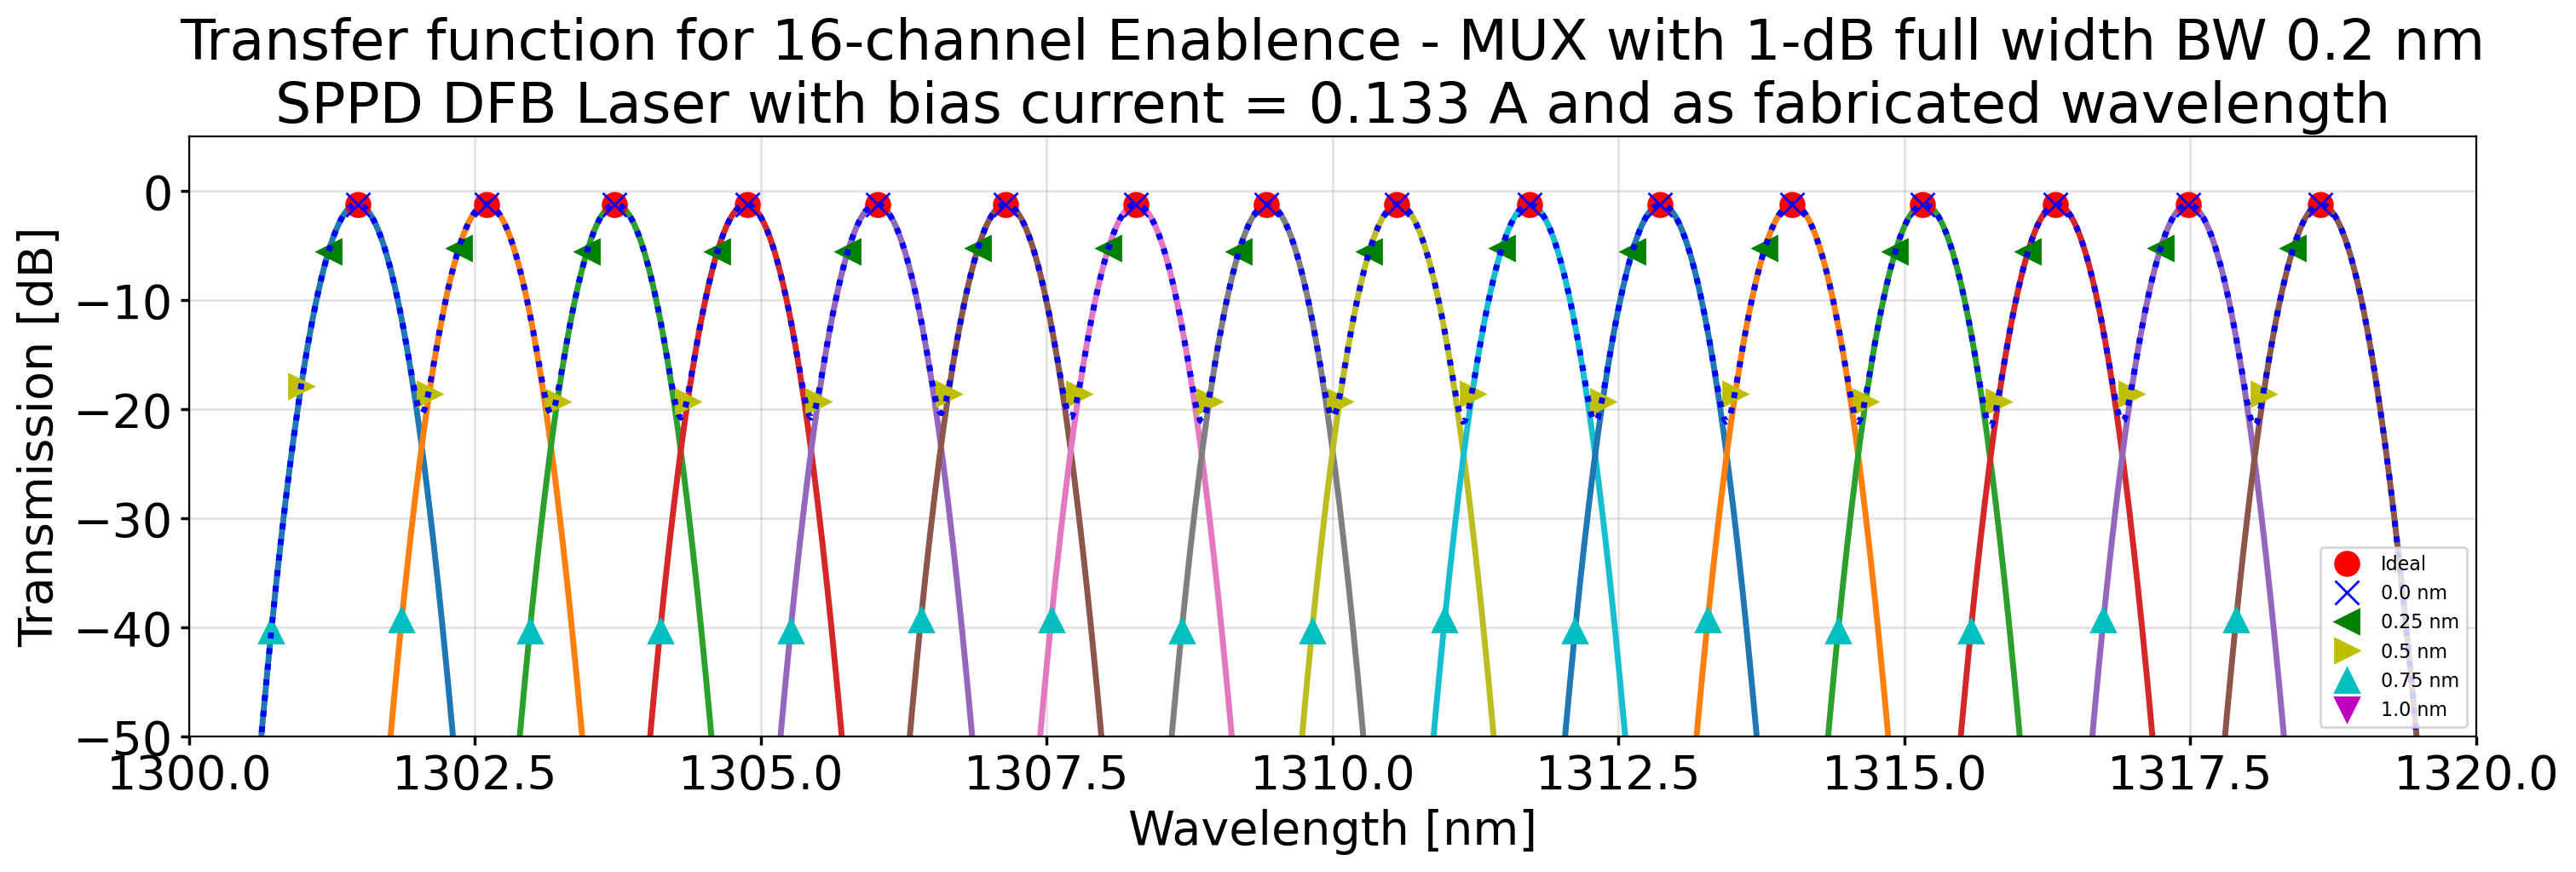

In [13]:
il_mag = 10**(-1.2/10)
bw_lambda = 0.12

lambda_sweep = np.linspace(1300, 1320, 1001)
tf_array = np.zeros((len(target_grid_array), len(lambda_sweep)))

for idd_grid, grid_val in enumerate(target_grid_array*1e9):
  tf_array[idd_grid,:] = il_mag*np.exp(-((lambda_sweep-grid_val)/bw_lambda)**2/4.343)


  
plt.figure(figsize=(15,5))
for idd_grid, grid_val in enumerate(target_grid_array*1e9):
  idd_ideal = np.argmin(np.abs(lambda_sweep - _lambda_array_as_fabricated_ideal[idd_grid]*1e9))
  idd_0p0nm = np.argmin(np.abs(lambda_sweep - _lambda_array_as_fabricated_0p0nm[idd_grid]*1e9))
  idd_0p25nm = np.argmin(np.abs(lambda_sweep - _lambda_array_as_fabricated_0p25nm[idd_grid]*1e9))
  idd_0p5nm = np.argmin(np.abs(lambda_sweep - _lambda_array_as_fabricated_0p5nm[idd_grid]*1e9))
  idd_0p75nm = np.argmin(np.abs(lambda_sweep - _lambda_array_as_fabricated_0p75nm[idd_grid]*1e9))
  idd_1p0nm = np.argmin(np.abs(lambda_sweep - _lambda_array_as_fabricated_1p0nm[idd_grid]*1e9))
  
  plt.plot(lambda_sweep, 10*np.log10(tf_array[idd_grid,:]), linewidth=2.5)
  if idd_grid == 0:
    plt.plot(lambda_sweep[idd_ideal], 10*np.log10(tf_array[idd_grid,idd_ideal]), 'o', color = 'r', label = 'Ideal')
    plt.plot(lambda_sweep[idd_0p0nm], 10*np.log10(tf_array[idd_grid,idd_0p0nm]), 'x', color = 'b', label = '0.0 nm')
    plt.plot(lambda_sweep[idd_0p25nm], 10*np.log10(tf_array[idd_grid,idd_0p25nm]), '<', color = 'g', label = '0.25 nm')
    plt.plot(lambda_sweep[idd_0p5nm], 10*np.log10(tf_array[idd_grid,idd_0p5nm]), '>', color = 'y', label = '0.5 nm')
    plt.plot(lambda_sweep[idd_0p75nm], 10*np.log10(tf_array[idd_grid,idd_0p75nm]), '^', color = 'c', label = '0.75 nm')
    plt.plot(lambda_sweep[idd_1p0nm], 10*np.log10(tf_array[idd_grid,idd_1p0nm]), 'v', color = 'm', label = '1.0 nm')
  else:
    plt.plot(lambda_sweep[idd_ideal], 10*np.log10(tf_array[idd_grid,idd_ideal]), 'o', color = 'r')
    plt.plot(lambda_sweep[idd_0p0nm], 10*np.log10(tf_array[idd_grid,idd_0p0nm]), 'x', color = 'b')
    plt.plot(lambda_sweep[idd_0p25nm], 10*np.log10(tf_array[idd_grid,idd_0p25nm]), '<', color = 'g')
    plt.plot(lambda_sweep[idd_0p5nm], 10*np.log10(tf_array[idd_grid,idd_0p5nm]), '>', color = 'y')
    plt.plot(lambda_sweep[idd_0p75nm], 10*np.log10(tf_array[idd_grid,idd_0p75nm]), '^', color = 'c')
    plt.plot(lambda_sweep[idd_1p0nm], 10*np.log10(tf_array[idd_grid,idd_1p0nm]), 'v', color = 'm')

plt.plot(lambda_sweep, 10*np.log10(np.sum(tf_array, axis=0)), linewidth=2.5, linestyle = ':', color = 'b')
plt.xlim([1300,1320])
plt.ylim([-50,5])
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission [dB]')
plt.title('Transfer function for 16-channel Enablence - MUX with 1-dB full width BW 0.2 nm\nSPPD DFB Laser with bias current = 0.133 A and as fabricated wavelength')
plt.grid(True)
plt.legend(fontsize = 8)

In [14]:
current_array = np.ones(16) * 0.133
_sppd_clm_optics_ideal.update(tc = 273+42.5, i_array=current_array)
_sppd_clm_optics_0p0nm.update(tc = 273+42.5, i_array=current_array)
_sppd_clm_optics_0p25nm.update(tc = 273+42.5, i_array=current_array)
_sppd_clm_optics_0p5nm.update(tc = 273+42.5, i_array=current_array)
_sppd_clm_optics_0p75nm.update(tc = 273+42.5, i_array=current_array)
_sppd_clm_optics_1p0nm.update(tc = 273+42.5, i_array=current_array)


_lambda_array_tec_on_ideal = deepcopy(_sppd_clm_optics_ideal._sppd_clm_pic._lambda_array)
_lambda_array_tec_on_0p0nm = deepcopy(_sppd_clm_optics_0p0nm._sppd_clm_pic._lambda_array)
_lambda_array_tec_on_0p25nm = deepcopy(_sppd_clm_optics_0p25nm._sppd_clm_pic._lambda_array)
_lambda_array_tec_on_0p5nm = deepcopy(_sppd_clm_optics_0p5nm._sppd_clm_pic._lambda_array)
_lambda_array_tec_on_0p75nm = deepcopy(_sppd_clm_optics_0p75nm._sppd_clm_pic._lambda_array)
_lambda_array_tec_on_1p0nm = deepcopy(_sppd_clm_optics_1p0nm._sppd_clm_pic._lambda_array)

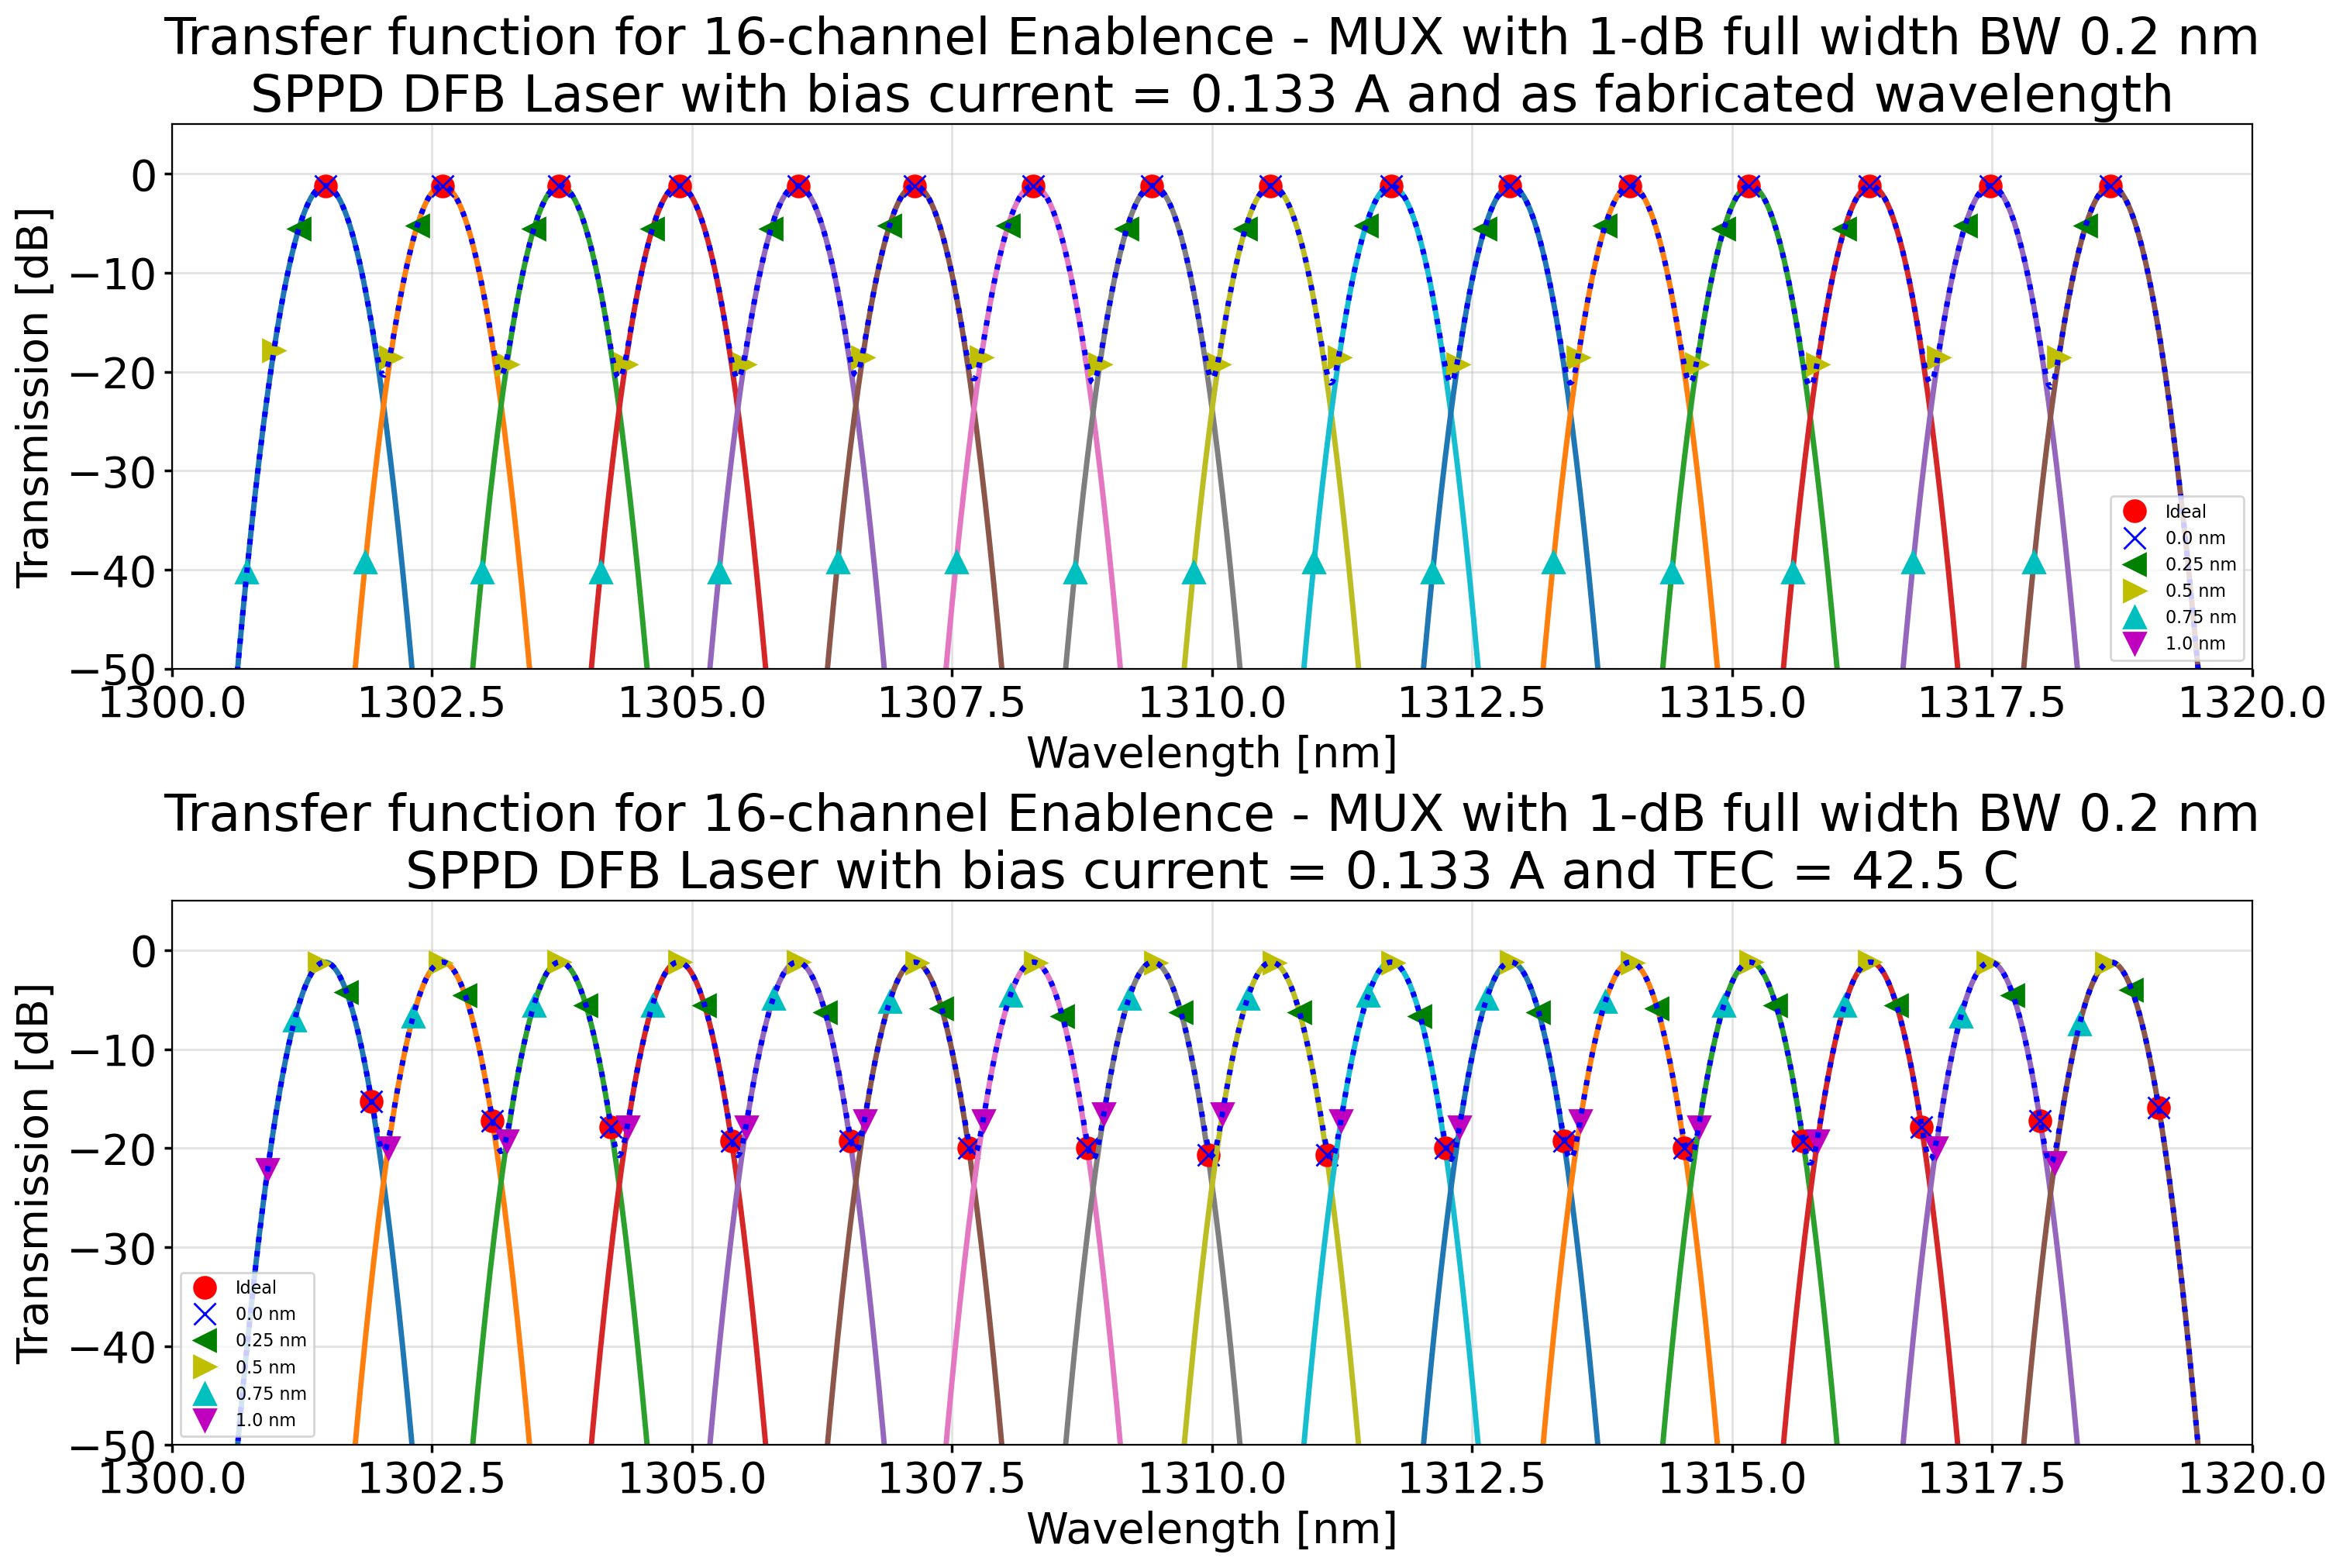

In [15]:
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
for idd_grid, grid_val in enumerate(target_grid_array*1e9):
  idd_ideal = np.argmin(np.abs(lambda_sweep - _lambda_array_as_fabricated_ideal[idd_grid]*1e9))
  idd_0p0nm = np.argmin(np.abs(lambda_sweep - _lambda_array_as_fabricated_0p0nm[idd_grid]*1e9))
  idd_0p25nm = np.argmin(np.abs(lambda_sweep - _lambda_array_as_fabricated_0p25nm[idd_grid]*1e9))
  idd_0p5nm = np.argmin(np.abs(lambda_sweep - _lambda_array_as_fabricated_0p5nm[idd_grid]*1e9))
  idd_0p75nm = np.argmin(np.abs(lambda_sweep - _lambda_array_as_fabricated_0p75nm[idd_grid]*1e9))
  idd_1p0nm = np.argmin(np.abs(lambda_sweep - _lambda_array_as_fabricated_1p0nm[idd_grid]*1e9))
  
  plt.plot(lambda_sweep, 10*np.log10(tf_array[idd_grid,:]), linewidth=2.5)
  if idd_grid == 0:
    plt.plot(lambda_sweep[idd_ideal], 10*np.log10(tf_array[idd_grid,idd_ideal]), 'o', color = 'r', label = 'Ideal')
    plt.plot(lambda_sweep[idd_0p0nm], 10*np.log10(tf_array[idd_grid,idd_0p0nm]), 'x', color = 'b', label = '0.0 nm')
    plt.plot(lambda_sweep[idd_0p25nm], 10*np.log10(tf_array[idd_grid,idd_0p25nm]), '<', color = 'g', label = '0.25 nm')
    plt.plot(lambda_sweep[idd_0p5nm], 10*np.log10(tf_array[idd_grid,idd_0p5nm]), '>', color = 'y', label = '0.5 nm')
    plt.plot(lambda_sweep[idd_0p75nm], 10*np.log10(tf_array[idd_grid,idd_0p75nm]), '^', color = 'c', label = '0.75 nm')
    plt.plot(lambda_sweep[idd_1p0nm], 10*np.log10(tf_array[idd_grid,idd_1p0nm]), 'v', color = 'm', label = '1.0 nm')
  else:
    plt.plot(lambda_sweep[idd_ideal], 10*np.log10(tf_array[idd_grid,idd_ideal]), 'o', color = 'r')
    plt.plot(lambda_sweep[idd_0p0nm], 10*np.log10(tf_array[idd_grid,idd_0p0nm]), 'x', color = 'b')
    plt.plot(lambda_sweep[idd_0p25nm], 10*np.log10(tf_array[idd_grid,idd_0p25nm]), '<', color = 'g')
    plt.plot(lambda_sweep[idd_0p5nm], 10*np.log10(tf_array[idd_grid,idd_0p5nm]), '>', color = 'y')
    plt.plot(lambda_sweep[idd_0p75nm], 10*np.log10(tf_array[idd_grid,idd_0p75nm]), '^', color = 'c')
    plt.plot(lambda_sweep[idd_1p0nm], 10*np.log10(tf_array[idd_grid,idd_1p0nm]), 'v', color = 'm')

plt.plot(lambda_sweep, 10*np.log10(np.sum(tf_array, axis=0)), linewidth=2.5, linestyle = ':', color = 'b')
plt.xlim([1300,1320])
plt.ylim([-50,5])
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission [dB]')
plt.title('Transfer function for 16-channel Enablence - MUX with 1-dB full width BW 0.2 nm\nSPPD DFB Laser with bias current = 0.133 A and as fabricated wavelength')
plt.grid(True)
plt.legend(fontsize = 8)

plt.subplot(2,1,2)
for idd_grid, grid_val in enumerate(target_grid_array*1e9):
  idd_tec_on_ideal = np.argmin(np.abs(lambda_sweep - _lambda_array_tec_on_ideal[idd_grid]*1e9))
  idd_tec_on_0p0nm = np.argmin(np.abs(lambda_sweep - _lambda_array_tec_on_0p0nm[idd_grid]*1e9))
  idd_tec_on_0p25nm = np.argmin(np.abs(lambda_sweep - _lambda_array_tec_on_0p25nm[idd_grid]*1e9))
  idd_tec_on_0p5nm = np.argmin(np.abs(lambda_sweep - _lambda_array_tec_on_0p5nm[idd_grid]*1e9))
  idd_tec_on_0p75nm = np.argmin(np.abs(lambda_sweep - _lambda_array_tec_on_0p75nm[idd_grid]*1e9))
  idd_tec_on_1p0nm = np.argmin(np.abs(lambda_sweep - _lambda_array_tec_on_1p0nm[idd_grid]*1e9))
  
  plt.plot(lambda_sweep, 10*np.log10(tf_array[idd_grid,:]), linewidth=2.5)
  if idd_grid == 0:
    plt.plot(lambda_sweep[idd_tec_on_ideal], 10*np.log10(tf_array[idd_grid,idd_tec_on_ideal]), 'o', color = 'r', label = 'Ideal')
    plt.plot(lambda_sweep[idd_tec_on_0p0nm], 10*np.log10(tf_array[idd_grid,idd_tec_on_0p0nm]), 'x', color = 'b', label = '0.0 nm')
    plt.plot(lambda_sweep[idd_tec_on_0p25nm], 10*np.log10(tf_array[idd_grid,idd_tec_on_0p25nm]), '<', color = 'g', label = '0.25 nm')
    plt.plot(lambda_sweep[idd_tec_on_0p5nm], 10*np.log10(tf_array[idd_grid,idd_tec_on_0p5nm]), '>', color = 'y', label = '0.5 nm')
    plt.plot(lambda_sweep[idd_tec_on_0p75nm], 10*np.log10(tf_array[idd_grid,idd_tec_on_0p75nm]), '^', color = 'c', label = '0.75 nm')
    plt.plot(lambda_sweep[idd_tec_on_1p0nm], 10*np.log10(tf_array[idd_grid,idd_tec_on_1p0nm]), 'v', color = 'm', label = '1.0 nm')
    
  else:
    plt.plot(lambda_sweep[idd_tec_on_ideal], 10*np.log10(tf_array[idd_grid,idd_tec_on_ideal]), 'o', color = 'r')
    plt.plot(lambda_sweep[idd_tec_on_0p0nm], 10*np.log10(tf_array[idd_grid,idd_tec_on_0p0nm]), 'x', color = 'b')
    plt.plot(lambda_sweep[idd_tec_on_0p25nm], 10*np.log10(tf_array[idd_grid,idd_tec_on_0p25nm]), '<', color = 'g')
    plt.plot(lambda_sweep[idd_tec_on_0p5nm], 10*np.log10(tf_array[idd_grid,idd_tec_on_0p5nm]), '>', color = 'y')
    plt.plot(lambda_sweep[idd_tec_on_0p75nm], 10*np.log10(tf_array[idd_grid,idd_tec_on_0p75nm]), '^', color = 'c')
    plt.plot(lambda_sweep[idd_tec_on_1p0nm], 10*np.log10(tf_array[idd_grid,idd_tec_on_1p0nm]), 'v', color = 'm')

plt.plot(lambda_sweep, 10*np.log10(np.sum(tf_array, axis=0)), linewidth=2.5, linestyle = ':', color = 'b')
plt.xlim([1300,1320])
plt.ylim([-50,5])
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission [dB]')
plt.title('Transfer function for 16-channel Enablence - MUX with 1-dB full width BW 0.2 nm\nSPPD DFB Laser with bias current = 0.133 A and TEC = 42.5 C')
plt.grid(True)
plt.legend(fontsize = 8)

In [16]:
_pk_pmic = PMIC()

dt = 100e-3
_pid_tec = pid_tec = PID(kp=0.5, ki=10*dt, kd=10*dt, dt=dt, umax=3, umin=-3)
_pid_idrive = [PID(kp=1/1000, ki=1/1000, kd=1/1000, dt=dt, umax = 1024, umin=-1024) for __ in range(len(wavelength_fabrication))]

controller_ideal = CONTROLLER(sppd_clm_optics = _sppd_clm_optics_ideal, pmic = _pk_pmic, drive_current_array=current_array, pid_tec = _pid_tec, pid_idrive = _pid_idrive, dt = dt)
start = time.time()
controller_ideal.calibrate(tc=273+35, temperature_array = np.linspace(30, 50, 201)+273, drive_current_array= np.linspace(0.1, 0.2, 101), power_wavelength_calibration=True, tec_temperature_tuning=True, drive_current_tuning=True, percent_range = np.linspace(0.5, 1.5, 101))
print(f"Calibration time for Ideal Controller: {time.time()-start:0.2f} s")

controller_data_export_dict = {}
controller_data_export_dict["Ideal"] = deepcopy(controller_ideal._data_export_dict)

controller_0p0nm = CONTROLLER(sppd_clm_optics = _sppd_clm_optics_0p0nm, pmic = _pk_pmic, drive_current_array=current_array, pid_tec = _pid_tec, pid_idrive = _pid_idrive, dt = dt)
start = time.time()
controller_0p0nm.calibrate(tc=273+35, temperature_array = np.linspace(30, 50, 201)+273, drive_current_array= np.linspace(0.1, 0.2, 101), power_wavelength_calibration=True, tec_temperature_tuning=True, drive_current_tuning=True, percent_range = np.linspace(0.5, 1.5, 101))
print(f"Calibration time for Controller on wavelength offset 0.0nm: {time.time()-start:0.2f} s")

controller_data_export_dict["0p0nm"] = deepcopy(controller_0p0nm._data_export_dict)

controller_0p25nm = CONTROLLER(sppd_clm_optics = _sppd_clm_optics_0p25nm, pmic = _pk_pmic, drive_current_array=current_array, pid_tec = _pid_tec, pid_idrive = _pid_idrive, dt = dt)
start = time.time()
controller_0p25nm.calibrate(tc=273+35, temperature_array = np.linspace(30, 50, 201)+273, drive_current_array= np.linspace(0.1, 0.2, 101), power_wavelength_calibration=True, tec_temperature_tuning=True, drive_current_tuning=True, percent_range = np.linspace(0.5, 1.5, 101))
print(f"Calibration time for Controller on wavelength offset 0.25nm: {time.time()-start:0.2f} s")

controller_data_export_dict["0p25nm"] = deepcopy(controller_0p25nm._data_export_dict)

controller_0p5nm = CONTROLLER(sppd_clm_optics = _sppd_clm_optics_0p5nm, pmic = _pk_pmic, drive_current_array=current_array, pid_tec = _pid_tec, pid_idrive = _pid_idrive, dt = dt)
start = time.time()
controller_0p5nm.calibrate(tc=273+35, temperature_array = np.linspace(30, 50, 201)+273, drive_current_array= np.linspace(0.1, 0.2, 101), power_wavelength_calibration=True, tec_temperature_tuning=True, drive_current_tuning=True, percent_range = np.linspace(0.5, 1.5, 101))
print(f"Calibration time for controller on wavelength offset 0.5nm: {time.time()-start:0.2f} s")

controller_data_export_dict["0p5nm"] = deepcopy(controller_0p5nm._data_export_dict)

controller_0p75nm = CONTROLLER(sppd_clm_optics = _sppd_clm_optics_0p75nm, pmic = _pk_pmic, drive_current_array=current_array, pid_tec = _pid_tec, pid_idrive = _pid_idrive, dt = dt)
start = time.time()
controller_0p75nm.calibrate(tc=273+35, temperature_array = np.linspace(30, 50, 201)+273, drive_current_array= np.linspace(0.1, 0.2, 101), power_wavelength_calibration=True, tec_temperature_tuning=True, drive_current_tuning=True, percent_range = np.linspace(0.5, 1.5, 101))
print(f"Calibration time for controller on wavelength offset 0.75nm: {time.time()-start:0.2f} s")

controller_data_export_dict["0p75nm"] = deepcopy(controller_0p75nm._data_export_dict)

controller_1p0nm = CONTROLLER(sppd_clm_optics = _sppd_clm_optics_1p0nm, pmic = _pk_pmic, drive_current_array=current_array, pid_tec = _pid_tec, pid_idrive = _pid_idrive, dt = dt)
start = time.time()
controller_1p0nm.calibrate(tc=273+35, temperature_array = np.linspace(30, 50, 201)+273, drive_current_array= np.linspace(0.1, 0.2, 101), power_wavelength_calibration=True, tec_temperature_tuning=True, drive_current_tuning=True, percent_range = np.linspace(0.5, 1.5, 101))
print(f"Calibration time for controller on wavelength offset 1.0nm: {time.time()-start:0.2f} s")

controller_data_export_dict["1p0nm"] = deepcopy(controller_1p0nm._data_export_dict)

Calibration time for Ideal Controller: 23.27 s
Calibration time for Controller on wavelength offset 0.0nm: 23.14 s
Calibration time for Controller on wavelength offset 0.25nm: 23.20 s
Calibration time for controller on wavelength offset 0.5nm: 22.83 s
Calibration time for controller on wavelength offset 0.75nm: 22.97 s
Calibration time for controller on wavelength offset 1.0nm: 22.72 s


In [17]:
controller_sims = ["Ideal", "0p0nm", "0p25nm", "0p5nm", "0p75nm", "1p0nm"]
for idd_sims in controller_sims:
  print(f"For {idd_sims} wavelength fabrication, we have the following calibration results:")
  if controller_data_export_dict[idd_sims]["warning_flag"]:
    print(f"Warning flag raised for {idd_sims}, please check the calibration results")
  else:
    print("Output optical power: {} mW".format(controller_data_export_dict[idd_sims]["output_power_array"]*1e3))
  print("TEC set point temperature: {} C\n".format(controller_data_export_dict[idd_sims]["tec_set_point_temperature"]-273))

For Ideal wavelength fabrication, we have the following calibration results:
Warning flag raised for Ideal, please check the calibration results
TEC set point temperature: 43.25 C

For 0p0nm wavelength fabrication, we have the following calibration results:
Warning flag raised for 0p0nm, please check the calibration results
TEC set point temperature: 41.11250000000001 C

For 0p25nm wavelength fabrication, we have the following calibration results:
Output optical power: [17.78502177 16.73269205 16.51729761 16.11742585 15.15802708 14.77858797
 15.37940318 15.53448642 15.63053055 14.22621131 15.4620235  15.44636753
 15.82274614 14.69038197 14.09646599 13.92699984] mW
TEC set point temperature: 39.981250000000045 C

For 0p5nm wavelength fabrication, we have the following calibration results:
Output optical power: [17.9242099  16.57236006 16.24183015 15.83061778 15.74722764 15.55247458
 15.04865556 15.21175619 14.25400958 15.62068289 15.21758729 14.39559137
 15.57783743 15.08917882 14.98293

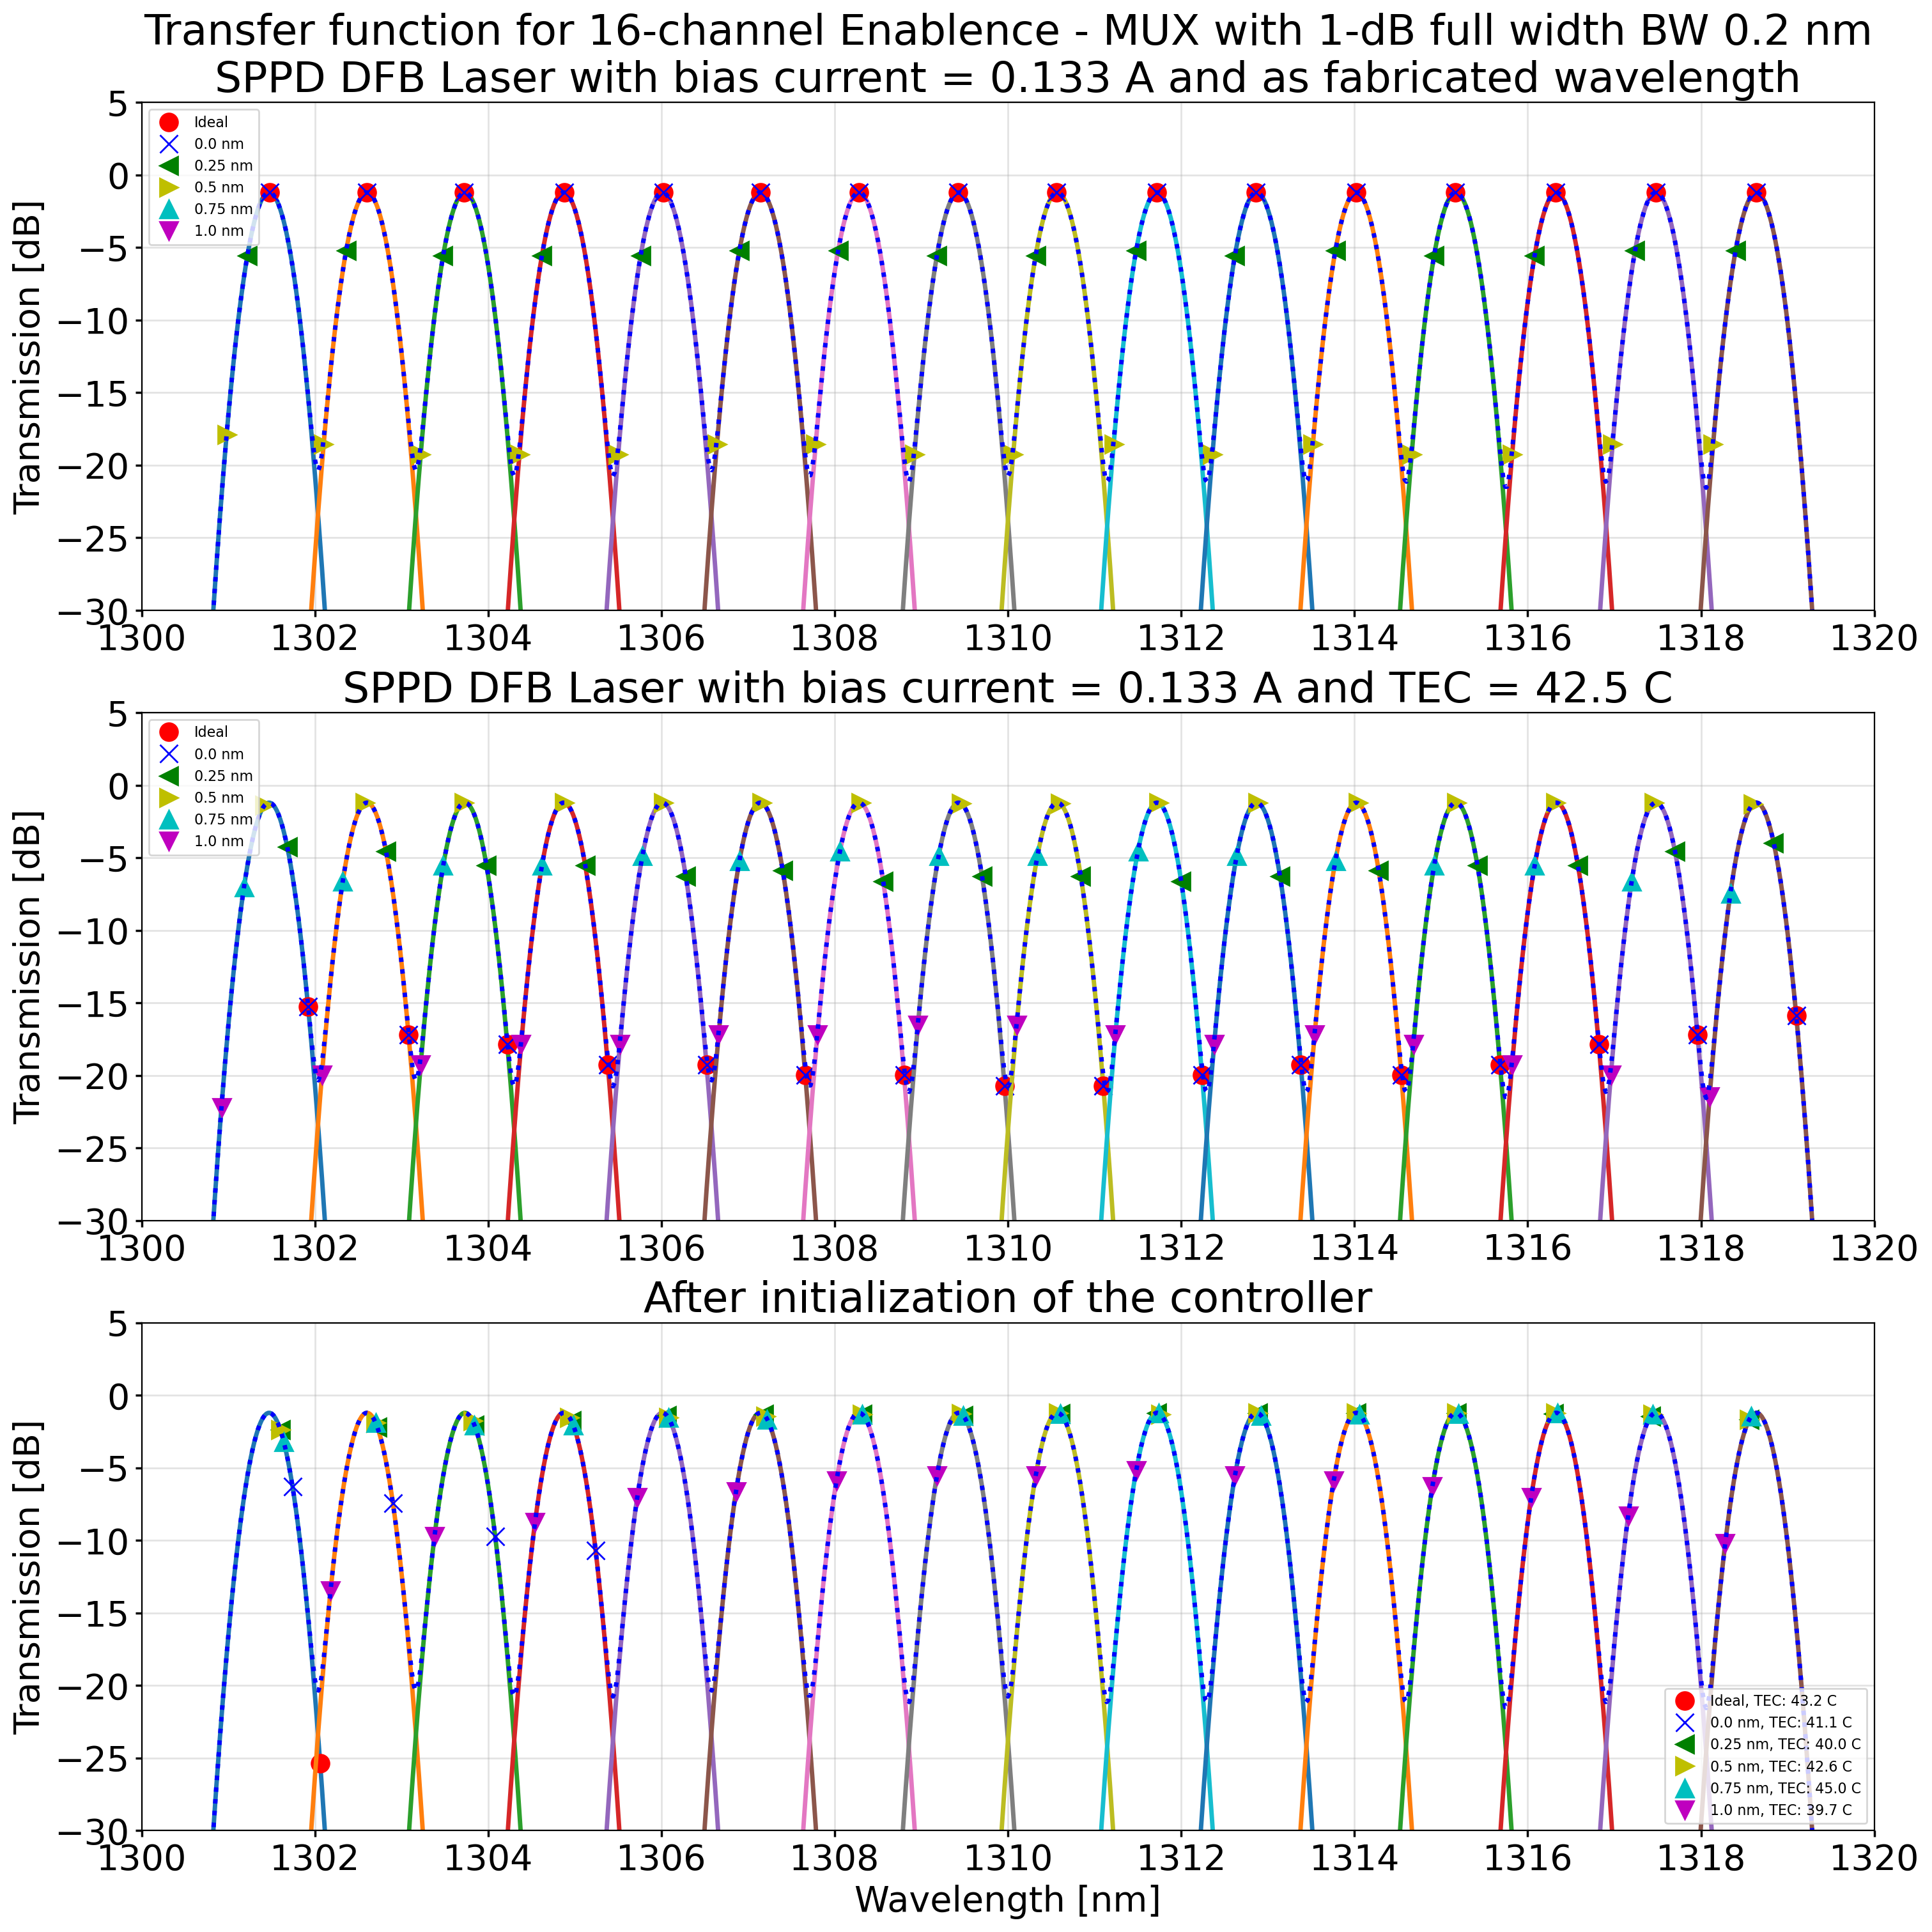

In [18]:
plt.figure(figsize=(15,15))
plt.subplot(3,1,1)
for idd_grid, grid_val in enumerate(target_grid_array*1e9):
  idd_ideal = np.argmin(np.abs(lambda_sweep - _lambda_array_as_fabricated_ideal[idd_grid]*1e9))
  idd_0p0nm = np.argmin(np.abs(lambda_sweep - _lambda_array_as_fabricated_0p0nm[idd_grid]*1e9))
  idd_0p25nm = np.argmin(np.abs(lambda_sweep - _lambda_array_as_fabricated_0p25nm[idd_grid]*1e9))
  idd_0p5nm = np.argmin(np.abs(lambda_sweep - _lambda_array_as_fabricated_0p5nm[idd_grid]*1e9))
  idd_0p75nm = np.argmin(np.abs(lambda_sweep - _lambda_array_as_fabricated_0p75nm[idd_grid]*1e9))
  idd_1p0nm = np.argmin(np.abs(lambda_sweep - _lambda_array_as_fabricated_1p0nm[idd_grid]*1e9))
  
  plt.plot(lambda_sweep, 10*np.log10(tf_array[idd_grid,:]), linewidth=2.5)
  if idd_grid == 0:
    plt.plot(lambda_sweep[idd_ideal], 10*np.log10(tf_array[idd_grid,idd_ideal]), 'o', color = 'r', label = 'Ideal')
    plt.plot(lambda_sweep[idd_0p0nm], 10*np.log10(tf_array[idd_grid,idd_0p0nm]), 'x', color = 'b', label = '0.0 nm')
    plt.plot(lambda_sweep[idd_0p25nm], 10*np.log10(tf_array[idd_grid,idd_0p25nm]), '<', color = 'g', label = '0.25 nm')
    plt.plot(lambda_sweep[idd_0p5nm], 10*np.log10(tf_array[idd_grid,idd_0p5nm]), '>', color = 'y', label = '0.5 nm')
    plt.plot(lambda_sweep[idd_0p75nm], 10*np.log10(tf_array[idd_grid,idd_0p75nm]), '^', color = 'c', label = '0.75 nm')
    plt.plot(lambda_sweep[idd_1p0nm], 10*np.log10(tf_array[idd_grid,idd_1p0nm]), 'v', color = 'm', label = '1.0 nm')
  else:
    plt.plot(lambda_sweep[idd_ideal], 10*np.log10(tf_array[idd_grid,idd_ideal]), 'o', color = 'r')
    plt.plot(lambda_sweep[idd_0p0nm], 10*np.log10(tf_array[idd_grid,idd_0p0nm]), 'x', color = 'b')
    plt.plot(lambda_sweep[idd_0p25nm], 10*np.log10(tf_array[idd_grid,idd_0p25nm]), '<', color = 'g')
    plt.plot(lambda_sweep[idd_0p5nm], 10*np.log10(tf_array[idd_grid,idd_0p5nm]), '>', color = 'y')
    plt.plot(lambda_sweep[idd_0p75nm], 10*np.log10(tf_array[idd_grid,idd_0p75nm]), '^', color = 'c')
    plt.plot(lambda_sweep[idd_1p0nm], 10*np.log10(tf_array[idd_grid,idd_1p0nm]), 'v', color = 'm')

plt.plot(lambda_sweep, 10*np.log10(np.sum(tf_array, axis=0)), linewidth=2.5, linestyle = ':', color = 'b')
plt.xlim([1300,1320])
plt.xticks(np.arange(1300,1322,2))
plt.ylim([-30,5])
# plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission [dB]')
plt.title('Transfer function for 16-channel Enablence - MUX with 1-dB full width BW 0.2 nm\nSPPD DFB Laser with bias current = 0.133 A and as fabricated wavelength')
plt.grid(True)
plt.legend(fontsize = 8)

plt.subplot(3,1,2)
for idd_grid, grid_val in enumerate(target_grid_array*1e9):
  idd_tec_on_ideal = np.argmin(np.abs(lambda_sweep - _lambda_array_tec_on_ideal[idd_grid]*1e9))
  idd_tec_on_0p0nm = np.argmin(np.abs(lambda_sweep - _lambda_array_tec_on_0p0nm[idd_grid]*1e9))
  idd_tec_on_0p25nm = np.argmin(np.abs(lambda_sweep - _lambda_array_tec_on_0p25nm[idd_grid]*1e9))
  idd_tec_on_0p5nm = np.argmin(np.abs(lambda_sweep - _lambda_array_tec_on_0p5nm[idd_grid]*1e9))
  idd_tec_on_0p75nm = np.argmin(np.abs(lambda_sweep - _lambda_array_tec_on_0p75nm[idd_grid]*1e9))
  idd_tec_on_1p0nm = np.argmin(np.abs(lambda_sweep - _lambda_array_tec_on_1p0nm[idd_grid]*1e9))
  
  plt.plot(lambda_sweep, 10*np.log10(tf_array[idd_grid,:]), linewidth=2.5)
  if idd_grid == 0:
    plt.plot(lambda_sweep[idd_tec_on_ideal], 10*np.log10(tf_array[idd_grid,idd_tec_on_ideal]), 'o', color = 'r', label = 'Ideal')
    plt.plot(lambda_sweep[idd_tec_on_0p0nm], 10*np.log10(tf_array[idd_grid,idd_tec_on_0p0nm]), 'x', color = 'b', label = '0.0 nm')
    plt.plot(lambda_sweep[idd_tec_on_0p25nm], 10*np.log10(tf_array[idd_grid,idd_tec_on_0p25nm]), '<', color = 'g', label = '0.25 nm')
    plt.plot(lambda_sweep[idd_tec_on_0p5nm], 10*np.log10(tf_array[idd_grid,idd_tec_on_0p5nm]), '>', color = 'y', label = '0.5 nm')
    plt.plot(lambda_sweep[idd_tec_on_0p75nm], 10*np.log10(tf_array[idd_grid,idd_tec_on_0p75nm]), '^', color = 'c', label = '0.75 nm')
    plt.plot(lambda_sweep[idd_tec_on_1p0nm], 10*np.log10(tf_array[idd_grid,idd_tec_on_1p0nm]), 'v', color = 'm', label = '1.0 nm')
    
  else:
    plt.plot(lambda_sweep[idd_tec_on_ideal], 10*np.log10(tf_array[idd_grid,idd_tec_on_ideal]), 'o', color = 'r')
    plt.plot(lambda_sweep[idd_tec_on_0p0nm], 10*np.log10(tf_array[idd_grid,idd_tec_on_0p0nm]), 'x', color = 'b')
    plt.plot(lambda_sweep[idd_tec_on_0p25nm], 10*np.log10(tf_array[idd_grid,idd_tec_on_0p25nm]), '<', color = 'g')
    plt.plot(lambda_sweep[idd_tec_on_0p5nm], 10*np.log10(tf_array[idd_grid,idd_tec_on_0p5nm]), '>', color = 'y')
    plt.plot(lambda_sweep[idd_tec_on_0p75nm], 10*np.log10(tf_array[idd_grid,idd_tec_on_0p75nm]), '^', color = 'c')
    plt.plot(lambda_sweep[idd_tec_on_1p0nm], 10*np.log10(tf_array[idd_grid,idd_tec_on_1p0nm]), 'v', color = 'm')

plt.plot(lambda_sweep, 10*np.log10(np.sum(tf_array, axis=0)), linewidth=2.5, linestyle = ':', color = 'b')
plt.xlim([1300,1320])
plt.xticks(np.arange(1300,1322,2))
plt.ylim([-30,5])
# plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission [dB]')
plt.title('SPPD DFB Laser with bias current = 0.133 A and TEC = 42.5 C')
plt.grid(True)
plt.legend(fontsize = 8)

plt.subplot(3,1,3)
for idd_grid, grid_val in enumerate(target_grid_array*1e9):
  idd_controller_ideal = np.argmin(np.abs(lambda_sweep - controller_data_export_dict["Ideal"]["output_lambda_array"][idd_grid]*1e9))
  idd_controller_0p0nm = np.argmin(np.abs(lambda_sweep - controller_data_export_dict["0p0nm"]["output_lambda_array"][idd_grid]*1e9))
  idd_controller_0p25nm = np.argmin(np.abs(lambda_sweep - controller_data_export_dict["0p25nm"]["output_lambda_array"][idd_grid]*1e9))
  idd_controller_0p5nm = np.argmin(np.abs(lambda_sweep - controller_data_export_dict["0p5nm"]["output_lambda_array"][idd_grid]*1e9))
  idd_controller_0p75nm = np.argmin(np.abs(lambda_sweep - controller_data_export_dict["0p75nm"]["output_lambda_array"][idd_grid]*1e9))
  idd_controller_1p0nm = np.argmin(np.abs(lambda_sweep - controller_data_export_dict["1p0nm"]["output_lambda_array"][idd_grid]*1e9))
  
  plt.plot(lambda_sweep, 10*np.log10(tf_array[idd_grid,:]), linewidth=2.5)
  if idd_grid == 0:
    plt.plot(lambda_sweep[idd_controller_ideal], 10*np.log10(tf_array[idd_grid,idd_controller_ideal]), 'o', color = 'r', label = f'Ideal, TEC: {controller_data_export_dict["Ideal"]["tec_set_point_temperature"]-273:0.1f} C')
    plt.plot(lambda_sweep[idd_controller_0p0nm], 10*np.log10(tf_array[idd_grid,idd_controller_0p0nm]), 'x', color = 'b', label = f'0.0 nm, TEC: {controller_data_export_dict["0p0nm"]["tec_set_point_temperature"]-273:0.1f} C')
    plt.plot(lambda_sweep[idd_controller_0p25nm], 10*np.log10(tf_array[idd_grid,idd_controller_0p25nm]), '<', color = 'g', label = f'0.25 nm, TEC: {controller_data_export_dict["0p25nm"]["tec_set_point_temperature"]-273:0.1f} C')
    plt.plot(lambda_sweep[idd_controller_0p5nm], 10*np.log10(tf_array[idd_grid,idd_controller_0p5nm]), '>', color = 'y', label = f'0.5 nm, TEC: {controller_data_export_dict["0p5nm"]["tec_set_point_temperature"]-273:0.1f} C')
    plt.plot(lambda_sweep[idd_controller_0p75nm], 10*np.log10(tf_array[idd_grid,idd_controller_0p75nm]), '^', color = 'c', label = f'0.75 nm, TEC: {controller_data_export_dict["0p75nm"]["tec_set_point_temperature"]-273:0.1f} C')
    plt.plot(lambda_sweep[idd_controller_1p0nm], 10*np.log10(tf_array[idd_grid,idd_controller_1p0nm]), 'v', color = 'm', label = f'1.0 nm, TEC: {controller_data_export_dict["1p0nm"]["tec_set_point_temperature"]-273:0.1f} C')
    
  else:
    plt.plot(lambda_sweep[idd_controller_ideal], 10*np.log10(tf_array[idd_grid,idd_controller_ideal]), 'o', color = 'r')
    plt.plot(lambda_sweep[idd_controller_0p0nm], 10*np.log10(tf_array[idd_grid,idd_controller_0p0nm]), 'x', color = 'b')
    plt.plot(lambda_sweep[idd_controller_0p25nm], 10*np.log10(tf_array[idd_grid,idd_controller_0p25nm]), '<', color = 'g')
    plt.plot(lambda_sweep[idd_controller_0p5nm], 10*np.log10(tf_array[idd_grid,idd_controller_0p5nm]), '>', color = 'y')
    plt.plot(lambda_sweep[idd_controller_0p75nm], 10*np.log10(tf_array[idd_grid,idd_controller_0p75nm]), '^', color = 'c')
    plt.plot(lambda_sweep[idd_controller_1p0nm], 10*np.log10(tf_array[idd_grid,idd_controller_1p0nm]), 'v', color = 'm')

plt.plot(lambda_sweep, 10*np.log10(np.sum(tf_array, axis=0)), linewidth=2.5, linestyle = ':', color = 'b')
plt.xlim([1300,1320])
plt.xticks(np.arange(1300,1322,2))
plt.ylim([-30,5])
plt.xlabel('Wavelength [nm]')
plt.ylabel('Transmission [dB]')
plt.title('After initialization of the controller')
plt.grid(True)
plt.legend(fontsize = 8)

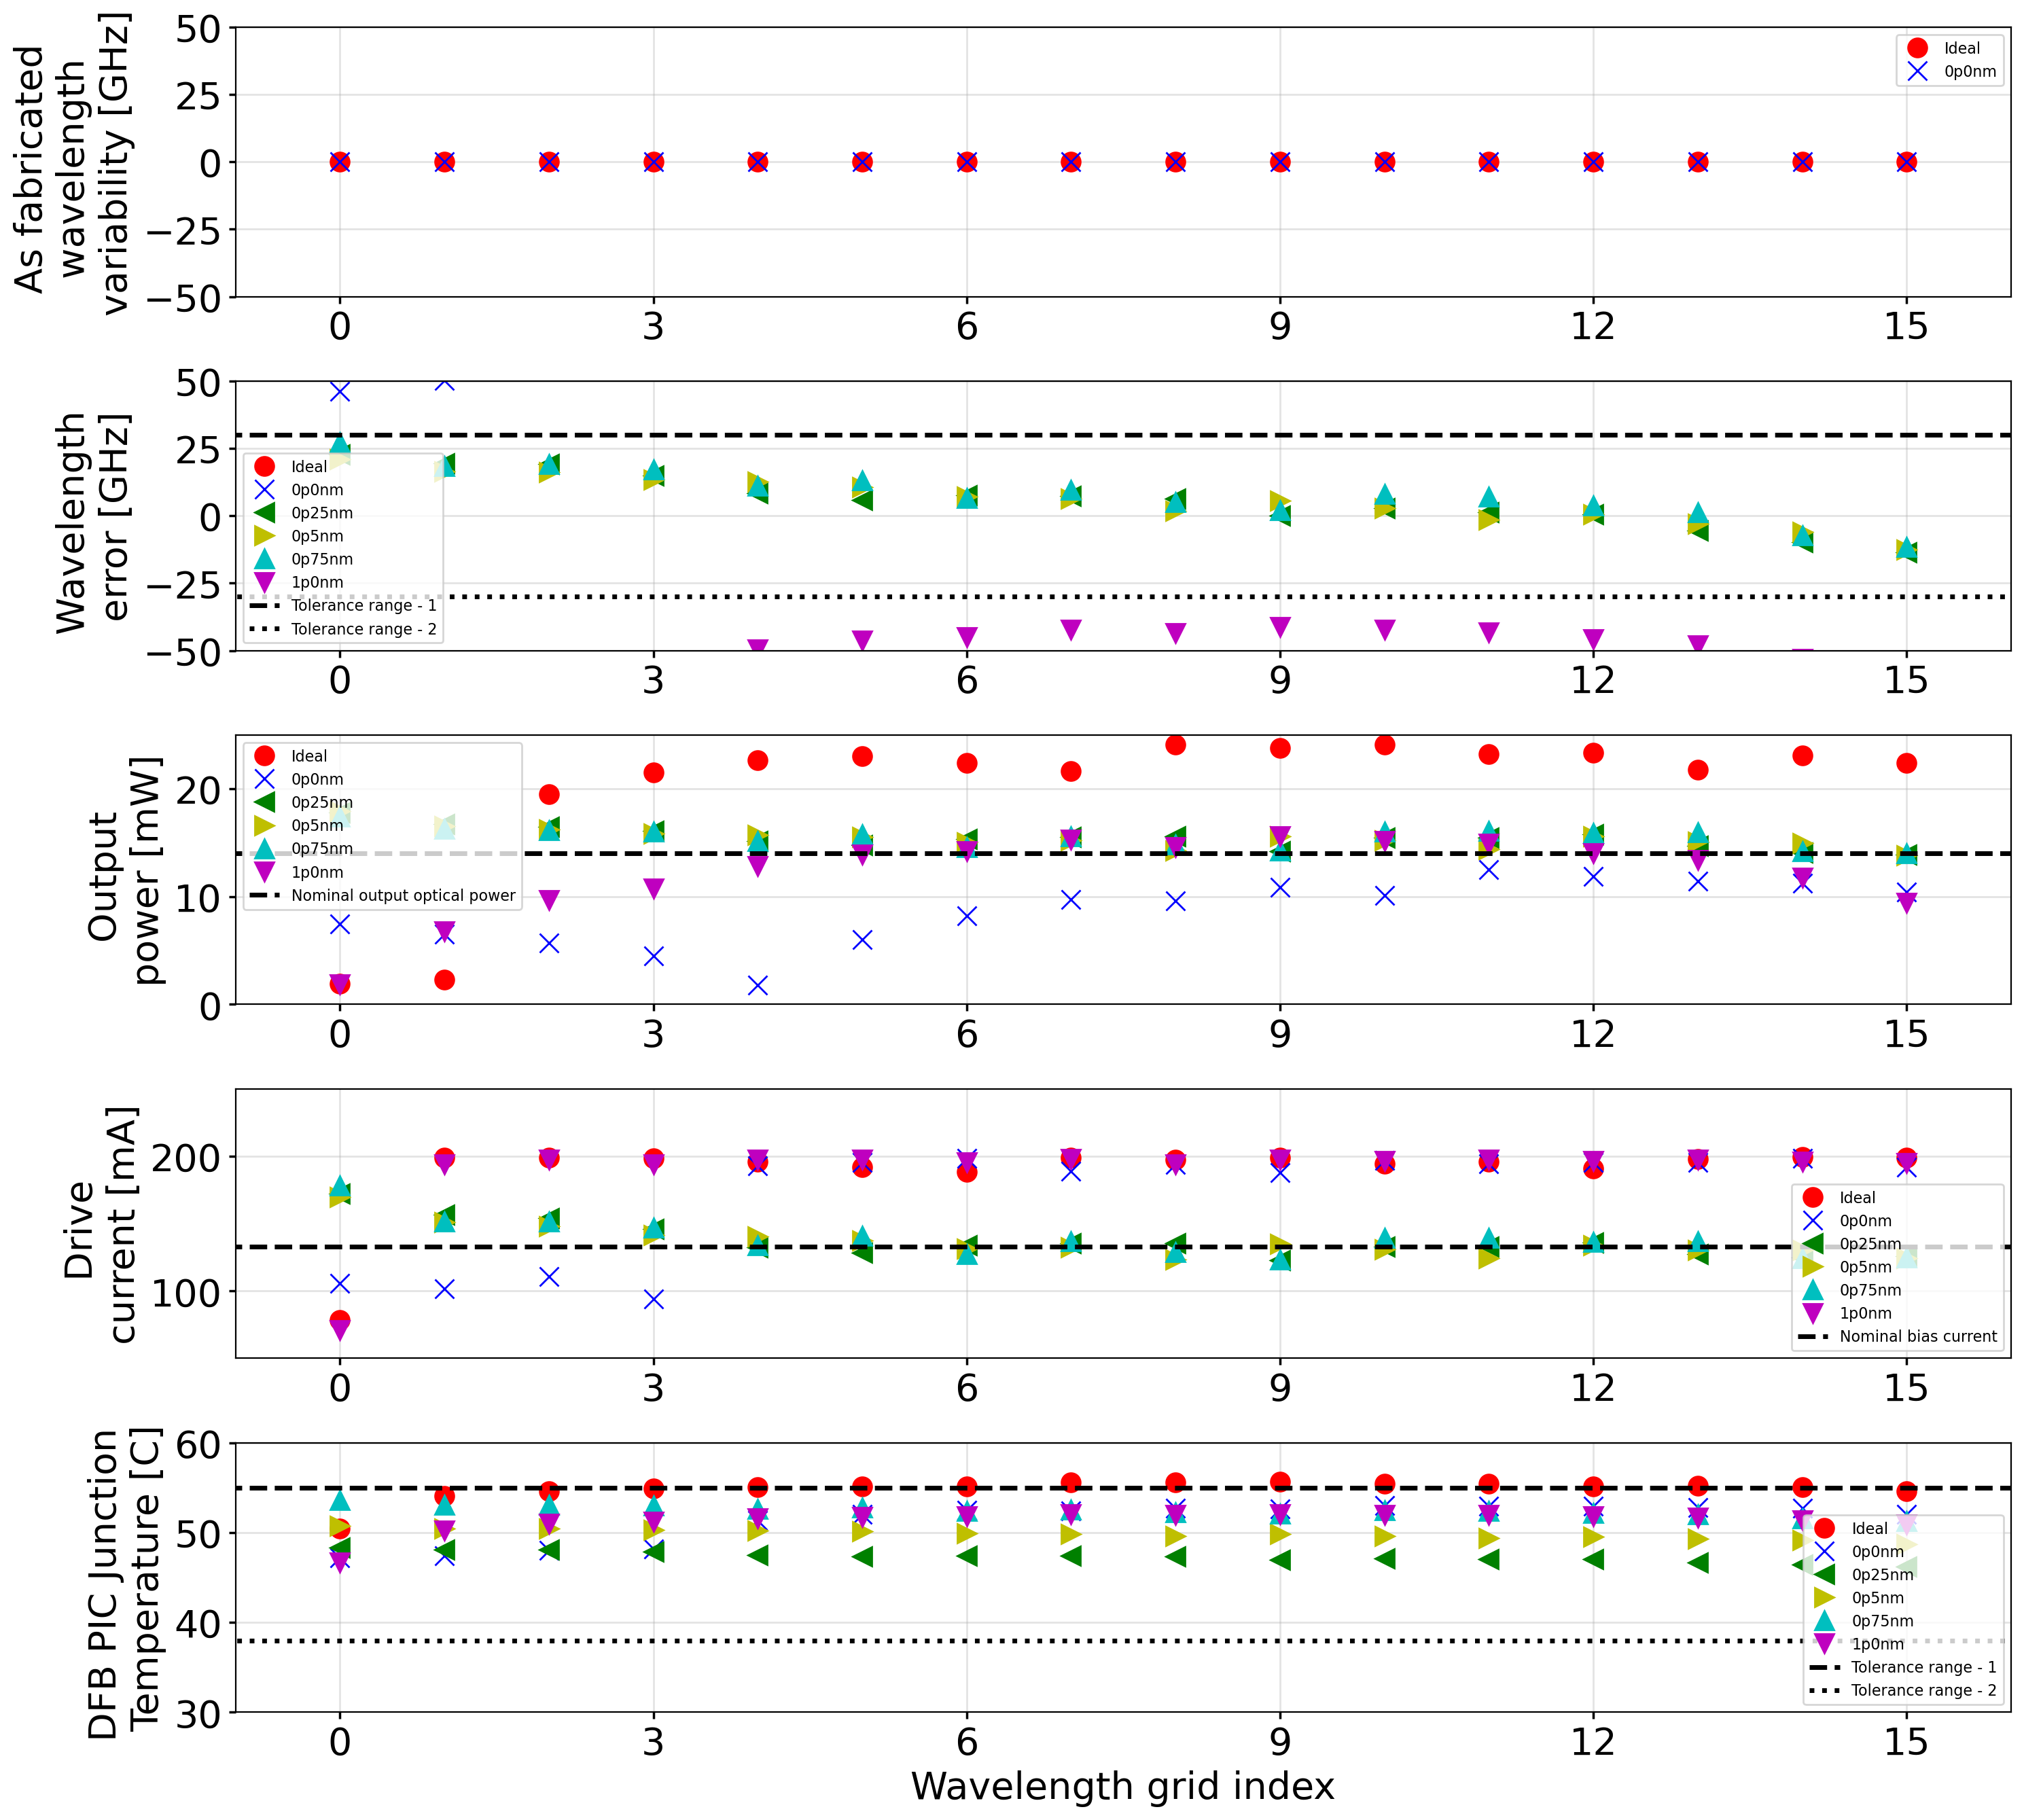

In [19]:
wavelength_error_ideal = wavelength_fabrication - target_grid_array
wavelength_error_0p0nm = wavelength_fabrication_ideal_0p0nm - target_grid_array 
wavelength_error_0p25nm = wavelength_fabrication_ideal_0p25nm - target_grid_array + 0.25e-9
wavelength_error_0p5nm = wavelength_fabrication_ideal_0p5nm - target_grid_array + 0.5e-9
wavelength_error_0p75nm = wavelength_fabrication_ideal_0p75nm - target_grid_array + 0.75e-9
wavelength_error_1p0nm = wavelength_fabrication_ideal_1p0nm - target_grid_array + 1.0e-9


plt.figure(figsize=(15,13.5))
plt.subplot(5,1,1)
controller_sims = ["Ideal", "0p0nm", "0p25nm", "0p5nm", "0p75nm", "1p0nm"]
color = ['r', 'b', 'g', 'y', 'c', 'm']
markerstyle = ['o', 'x', '<', '>', '^', 'v']
plt.plot(np.arange(0, 16, 1), wavelength_error_ideal*1e9/0.1*17, markerstyle[0], color = color[0], label = controller_sims[0])
plt.plot(np.arange(0, 16, 1), wavelength_error_0p0nm*1e9/0.1*17,  markerstyle[1], color = color[1], label = controller_sims[1])
plt.legend(fontsize = 8)
plt.xlim([-1,16])
plt.xticks(np.arange(0, len(target_grid_array), 3))
plt.yticks(np.arange(-75, 75, 25))
plt.ylim([-50, 50])
plt.ylabel('As fabricated \nwavelength \nvariability [GHz]')
plt.subplot(5,1,2)
for idd_sims, sims in enumerate(controller_sims):
  wavelength_error = controller_data_export_dict[sims]["output_lambda_array"]*1e9 - target_grid_array*1e9
  for idd_grid, grid_val in enumerate(target_grid_array*1e9):
    if idd_grid == 0:
      plt.plot(idd_grid, wavelength_error[idd_grid]/0.1*17, markerstyle[idd_sims], color = color[idd_sims], label = sims)
    else:
      plt.plot(idd_grid, wavelength_error[idd_grid]/0.1*17, markerstyle[idd_sims], color = color[idd_sims])
plt.plot(np.linspace(-10, 26,16), 30*np.ones(16), linestyle = '--', color='k', label = 'Tolerance range - 1')
plt.plot(np.linspace(-10, 26,16), -30*np.ones(16), linestyle = ':', color='k', label = 'Tolerance range - 2')
plt.legend(fontsize = 8)
plt.xlim([-1,16])
plt.xticks(np.arange(0, len(target_grid_array), 3))
plt.yticks(np.arange(-75, 75, 25))
plt.ylim([-50, 50])
# plt.xlabel('Wavelength grid index')
plt.ylabel('Wavelength \nerror [GHz]')
plt.subplot(5,1,3)
for idd_sims, sims in enumerate(controller_sims):
  output_power = controller_data_export_dict[sims]["output_power_array"]
  for idd_grid, grid_val in enumerate(target_grid_array*1e9):
    if idd_grid == 0:
      plt.plot(idd_grid, output_power[idd_grid]*1e3, markerstyle[idd_sims], color = color[idd_sims], label = sims)
    else:
      plt.plot(idd_grid, output_power[idd_grid]*1e3, markerstyle[idd_sims], color = color[idd_sims])
plt.plot(np.linspace(-10, 26,16), 14*np.ones(16), linestyle = '--', color='k', label = 'Nominal output optical power')
plt.legend(fontsize = 8)
plt.xlim([-1,16])
plt.xticks(np.arange(0, len(target_grid_array), 3))
plt.ylim([0, 25])
# plt.xlabel('Wavelength grid index')
plt.ylabel('Output \npower [mW]')
plt.subplot(5,1,4)
for idd_sims, sims in enumerate(controller_sims):
  drive_current = controller_data_export_dict[sims]["drive_current_array"]
  for idd_grid, grid_val in enumerate(target_grid_array*1e9):
    if idd_grid == 0:
      plt.plot(idd_grid, drive_current[idd_grid]*1e3, markerstyle[idd_sims], color = color[idd_sims], label = sims)
    else:
      plt.plot(idd_grid, drive_current[idd_grid]*1e3, markerstyle[idd_sims], color = color[idd_sims])
plt.plot(np.linspace(-10, 26,16), 133*np.ones(16), linestyle = '--', color='k', label = 'Nominal bias current')
plt.legend(fontsize = 8)
plt.xlim([-1,16])
plt.xticks(np.arange(0, len(target_grid_array), 3))
plt.ylim([50, 250])
# plt.xlabel('Wavelength grid index')
plt.ylabel('Drive \ncurrent [mA]')
plt.subplot(5,1,5)
for idd_sims, sims in enumerate(controller_sims):
  laser_junction_temperature = controller_data_export_dict[sims]["laser_junction_temperature_array"]
  for idd_grid, grid_val in enumerate(target_grid_array*1e9):
    if idd_grid == 0:
      plt.plot(idd_grid, laser_junction_temperature[idd_grid]-273, markerstyle[idd_sims], color = color[idd_sims], label = sims)
    else:
      plt.plot(idd_grid, laser_junction_temperature[idd_grid]-273, markerstyle[idd_sims], color = color[idd_sims])
plt.plot(np.linspace(-10, 26,16), 55*np.ones(16), linestyle = '--', color='k', label = 'Tolerance range - 1')
plt.plot(np.linspace(-10, 26,16), 38*np.ones(16), linestyle = ':', color='k', label = 'Tolerance range - 2')
plt.legend(fontsize = 8)
plt.xlim([-1,16])
plt.xticks(np.arange(0, len(target_grid_array), 3))
plt.ylim([30, 60])
plt.xlabel('Wavelength grid index')
plt.ylabel('DFB PIC Junction \nTemperature [C]')
plt.tight_layout()
  